In [1]:
import sys
sys.path.append("..")

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, TrainerCallback
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from time import localtime, strftime
from D2.data_selector import DataSelector

SEED = 42

In [2]:
# tmp_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
# fake_batch = {
#     "input_ids": torch.ones(32, 512, dtype=torch.long).to("cuda"), 
#     "attention_mask": torch.ones(32, 512, dtype=torch.long).to("cuda")
# }
# fake_labels = torch.zeros(32, 3).to("cuda")
# tmp_model.to("cuda")
# logits = tmp_model(**fake_batch).logits
# loss = ((logits - fake_labels) ** 2).mean()
# loss.backward()

In [3]:
ds = DataSelector("../D2/data.csv")
data = ds.select_data(30000, length=5, scale_sd=30, seed=SEED)
data['conversation'] = data['conversation'].astype(str)

/home/alexlu/Documents/Programming/alexlu07/Scires/11th/VAD/M1.5/../D2/data_selector.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(filepath)


Filtering...
Calculating counts...
Grabbing data...


array([[<Axes: title={'center': 'V'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'D'}>, <Axes: >]], dtype=object)

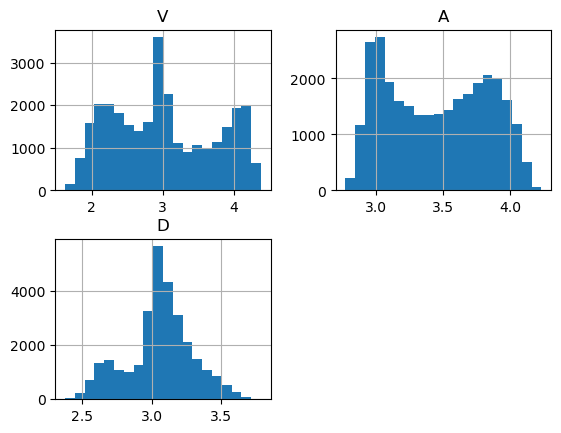

In [4]:
data.hist(bins=20)

In [5]:
raw_dataset = Dataset.from_pandas(data)
train_testval = raw_dataset.train_test_split(test_size=0.2, seed=SEED)
test_val = train_testval['test'].train_test_split(test_size=0.5, seed=SEED)

dataset = DatasetDict({
    'train': train_testval['train'],
    'test': test_val['test'],
    'val': test_val['train']}
)

In [6]:
dataset['train'][0]

{'text': ['Where?',
  'Do you know of the Water of Life?... the Truthsayer drug?',
  'I have heard of it. -- REVEREND MOTHER It is very dangerous... very painful. The Bene Gesserit sisterhood drink it to see within.... There is a place terrifying to us... to women. It is said a man will come... the Kwisatz Haderach... he will go where we cannot... Many men have tried...',
  'Did they try and fail?',
  'They tried and died.... Jessica!'],
 'conversation': 'L173660',
 'source': 'Cornell',
 'V': 2.122368574142456,
 'A': 3.673941612243652,
 'D': 2.8426384925842285,
 '__index_level_0__': 134165}

In [7]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def mask_data(mask_ratio):
    def mask_function(examples):
        mask_idx = np.random.choice(len(examples["text"]), int(mask_ratio * len(examples["text"])), replace=False)
        convs = examples["text"].copy()
        for i in mask_idx:
            convs[i][-1] = tokenizer.mask_token
        
        return {"text": convs}

    return mask_function

def preprocess_data(examples):
    role_names = ("speaker", "respondent")

    convs = [
        tokenizer.apply_chat_template(
            [{"role": role_names[i % 2], "content": x} for i, x in enumerate(m)], 
            tokenize=False)
        for m in examples["text"]
    ]

    encoding = tokenizer(convs, max_length=512, truncation=True)
    encoding["labels"] = list(zip(examples["V"], examples["A"], examples["D"]))

    return encoding


dataset["train"] = dataset["train"].map(mask_data(1), batched=True, batch_size=100000)
dataset["masked_val"] = dataset["val"].map(mask_data(1), batched=True, batch_size=100000)
dataset["masked_test"] = dataset["test"].map(mask_data(1), batched=True, batch_size=100000)
tokenized_dataset = dataset.map(preprocess_data, batched=True, batch_size=100000, 
                                remove_columns=['text', 'conversation', 'source', 'V', 'A', 'D', '__index_level_0__'])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]


No chat template is defined for this tokenizer - using a default chat template that implements the ChatML format (without BOS/EOS tokens!). If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [8]:
def get_model():
    return AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = 4/(1+np.exp(-logits)) + 1

    metrics = {
        "mae": mean_absolute_error(labels, logits, multioutput="raw_values").tolist(),
        "mse": mean_squared_error(labels, logits, multioutput="raw_values").tolist(),
        "pearsonr": [pearsonr(logits[:, i], labels[:, i])[0] for i in range(len(logits[0]))],
        "r_squared": r2_score(labels, logits, multioutput="raw_values").tolist(),
    }

    return {f"{m}_{s}": metrics[m][i] for i, s in enumerate("VAD") for m in metrics}

In [10]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = torch.sigmoid(outputs['logits']) * 4 + 1
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [11]:
from transformers.trainer_callback import TrainerControl, TrainerState
from transformers.training_args import TrainingArguments


class MaskEvalCallback(TrainerCallback):
    def __init__(self):
        training_args = TrainingArguments(
            output_dir="/tmp/tmp_trainer",
            per_device_eval_batch_size=32,
            report_to="none",
        )

        self.trainer = RegressionTrainer(
            model=get_model(),
            args=training_args,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )


    def on_evaluate(self, args, state, control, model=None, **kwargs):
        self.trainer.model = model
        print(self.trainer.evaluate(tokenized_dataset["masked_val"]))

In [12]:
raise Exception

Exception: 

In [13]:
dir_name = strftime("%b-%d-%y-%H:%M:%S", localtime())
# dir_name = "Jan-01-24-14:55:56"
# dir_name = "Jan-02-24-08:40:31"
dir_name = "Jan-02-24-20:30:44"
# dir_name = "test"

training_args = TrainingArguments(
    output_dir=f"results/{dir_name}",
    logging_dir=f"results/{dir_name}/runs",
    evaluation_strategy="epoch",
    per_device_train_batch_size=28,
    per_device_eval_batch_size=28,
    learning_rate=2e-6,
    max_grad_norm=1.0,
    num_train_epochs=20,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_strategy="epoch",
    report_to="none",
    save_strategy="epoch",
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    disable_tqdm=False
)

trainer = RegressionTrainer(
    model_init=get_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[MaskEvalCallback()]
)

trainer.train(resume_from_checkpoint=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN th

  0%|          | 0/17160 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.1598, 'learning_rate': 8.888888888888888e-07, 'epoch': 12.0}


  0%|          | 0/108 [00:00<?, ?it/s]

{'eval_loss': 0.12377014011144638, 'eval_mae_V': 0.38515615463256836, 'eval_mse_V': 0.24640832841396332, 'eval_pearsonr_V': 0.724029076963006, 'eval_r_squared_V': 0.5232024681732951, 'eval_mae_A': 0.24445274472236633, 'eval_mse_A': 0.08909256756305695, 'eval_pearsonr_A': 0.6652750749350005, 'eval_r_squared_A': 0.37636658295687675, 'eval_mae_D': 0.1389591246843338, 'eval_mse_D': 0.03580949828028679, 'eval_pearsonr_D': 0.6139341079456359, 'eval_r_squared_D': 0.36001465566268565, 'eval_runtime': 12.3296, 'eval_samples_per_second': 243.317, 'eval_steps_per_second': 8.759, 'epoch': 12.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.19478560984134674, 'eval_mae_V': 0.5037513971328735, 'eval_mse_V': 0.4201173782348633, 'eval_pearsonr_V': 0.486747674165562, 'eval_r_squared_V': 0.1870777035251816, 'eval_mae_A': 0.28044047951698303, 'eval_mse_A': 0.1140744611620903, 'eval_pearsonr_A': 0.4642484035710222, 'eval_r_squared_A': 0.20149730643810504, 'eval_mae_D': 0.16883216798305511, 'eval_mse_D': 0.0501650832593441, 'eval_pearsonr_D': 0.3719453301545854, 'eval_r_squared_D': 0.10345164293461806, 'eval_runtime': 10.9265, 'eval_samples_per_second': 274.563, 'eval_steps_per_second': 8.603}
{'loss': 0.1586, 'learning_rate': 7.777777777777778e-07, 'epoch': 13.0}


  0%|          | 0/108 [00:00<?, ?it/s]

{'eval_loss': 0.1226266473531723, 'eval_mae_V': 0.38409924507141113, 'eval_mse_V': 0.24807210266590118, 'eval_pearsonr_V': 0.7226607020488984, 'eval_r_squared_V': 0.5199832394006234, 'eval_mae_A': 0.23795314133167267, 'eval_mse_A': 0.08450961858034134, 'eval_pearsonr_A': 0.6702732305769252, 'eval_r_squared_A': 0.4084473772158216, 'eval_mae_D': 0.1385066658258438, 'eval_mse_D': 0.03529836982488632, 'eval_pearsonr_D': 0.6187552657429058, 'eval_r_squared_D': 0.3691492889060878, 'eval_runtime': 12.3513, 'eval_samples_per_second': 242.89, 'eval_steps_per_second': 8.744, 'epoch': 13.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.1940615177154541, 'eval_mae_V': 0.5003289580345154, 'eval_mse_V': 0.41867902874946594, 'eval_pearsonr_V': 0.484317768579365, 'eval_r_squared_V': 0.18986114607803317, 'eval_mae_A': 0.2788057029247284, 'eval_mse_A': 0.11348229646682739, 'eval_pearsonr_A': 0.46399943887675554, 'eval_r_squared_A': 0.20564330396140262, 'eval_mae_D': 0.16933807730674744, 'eval_mse_D': 0.05002358928322792, 'eval_pearsonr_D': 0.36936807203192235, 'eval_r_squared_D': 0.10598009800838493, 'eval_runtime': 10.8884, 'eval_samples_per_second': 275.522, 'eval_steps_per_second': 8.633}
{'loss': 0.1547, 'learning_rate': 6.666666666666666e-07, 'epoch': 14.0}


  0%|          | 0/108 [00:00<?, ?it/s]

{'eval_loss': 0.12912388145923615, 'eval_mae_V': 0.38888218998908997, 'eval_mse_V': 0.26026394963264465, 'eval_pearsonr_V': 0.7121063961781522, 'eval_r_squared_V': 0.4963916791060571, 'eval_mae_A': 0.24623100459575653, 'eval_mse_A': 0.09085901081562042, 'eval_pearsonr_A': 0.665483051146045, 'eval_r_squared_A': 0.36400188178617743, 'eval_mae_D': 0.13962335884571075, 'eval_mse_D': 0.03624846041202545, 'eval_pearsonr_D': 0.6112010083884528, 'eval_r_squared_D': 0.35216911928924444, 'eval_runtime': 12.238, 'eval_samples_per_second': 245.138, 'eval_steps_per_second': 8.825, 'epoch': 14.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.19876766204833984, 'eval_mae_V': 0.5047041177749634, 'eval_mse_V': 0.43096333742141724, 'eval_pearsonr_V': 0.4799230169575768, 'eval_r_squared_V': 0.1660902296688359, 'eval_mae_A': 0.28119853138923645, 'eval_mse_A': 0.1151193305850029, 'eval_pearsonr_A': 0.4628046997962769, 'eval_r_squared_A': 0.19418384729178562, 'eval_mae_D': 0.1689833402633667, 'eval_mse_D': 0.050220027565956116, 'eval_pearsonr_D': 0.3684377806445792, 'eval_r_squared_D': 0.10246888210465788, 'eval_runtime': 10.9189, 'eval_samples_per_second': 274.752, 'eval_steps_per_second': 8.609}
{'loss': 0.1533, 'learning_rate': 5.555555555555555e-07, 'epoch': 15.0}


  0%|          | 0/108 [00:00<?, ?it/s]

{'eval_loss': 0.12928038835525513, 'eval_mae_V': 0.38672831654548645, 'eval_mse_V': 0.25765833258628845, 'eval_pearsonr_V': 0.7156896341327822, 'eval_r_squared_V': 0.5014346964388273, 'eval_mae_A': 0.2492465227842331, 'eval_mse_A': 0.09395477175712585, 'eval_pearsonr_A': 0.6614886329595595, 'eval_r_squared_A': 0.3423318160996851, 'eval_mae_D': 0.1396818310022354, 'eval_mse_D': 0.03622845560312271, 'eval_pearsonr_D': 0.6125873001185135, 'eval_r_squared_D': 0.3525266669035585, 'eval_runtime': 12.3264, 'eval_samples_per_second': 243.379, 'eval_steps_per_second': 8.762, 'epoch': 15.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.20172013342380524, 'eval_mae_V': 0.5061944127082825, 'eval_mse_V': 0.4367574155330658, 'eval_pearsonr_V': 0.4779547621270841, 'eval_r_squared_V': 0.15487895091314297, 'eval_mae_A': 0.2828630805015564, 'eval_mse_A': 0.11750294268131256, 'eval_pearsonr_A': 0.46126348027316316, 'eval_r_squared_A': 0.177498519887474, 'eval_mae_D': 0.17025162279605865, 'eval_mse_D': 0.05089986324310303, 'eval_pearsonr_D': 0.36562901357643895, 'eval_r_squared_D': 0.09031954161410127, 'eval_runtime': 10.87, 'eval_samples_per_second': 275.989, 'eval_steps_per_second': 8.648}
{'loss': 0.1505, 'learning_rate': 4.444444444444444e-07, 'epoch': 16.0}


  0%|          | 0/108 [00:00<?, ?it/s]

{'eval_loss': 0.1337810903787613, 'eval_mae_V': 0.3919084370136261, 'eval_mse_V': 0.26971235871315, 'eval_pearsonr_V': 0.7075797417170033, 'eval_r_squared_V': 0.47810954506212744, 'eval_mae_A': 0.2505927085876465, 'eval_mse_A': 0.0952506810426712, 'eval_pearsonr_A': 0.6543382320426548, 'eval_r_squared_A': 0.33326154929504215, 'eval_mae_D': 0.1398768275976181, 'eval_mse_D': 0.036380257457494736, 'eval_pearsonr_D': 0.608938035494345, 'eval_r_squared_D': 0.3498123258324768, 'eval_runtime': 12.2501, 'eval_samples_per_second': 244.896, 'eval_steps_per_second': 8.816, 'epoch': 16.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.20565767586231232, 'eval_mae_V': 0.510507345199585, 'eval_mse_V': 0.4482027590274811, 'eval_pearsonr_V': 0.4743838295078481, 'eval_r_squared_V': 0.1327327195243453, 'eval_mae_A': 0.28278055787086487, 'eval_mse_A': 0.11791959404945374, 'eval_pearsonr_A': 0.46029132312381515, 'eval_r_squared_A': 0.17458238193729525, 'eval_mae_D': 0.16998369991779327, 'eval_mse_D': 0.050850749015808105, 'eval_pearsonr_D': 0.36409892499367025, 'eval_r_squared_D': 0.09119672750747398, 'eval_runtime': 10.7583, 'eval_samples_per_second': 278.854, 'eval_steps_per_second': 8.737}
{'loss': 0.1492, 'learning_rate': 3.333333333333333e-07, 'epoch': 17.0}


  0%|          | 0/108 [00:00<?, ?it/s]

{'eval_loss': 0.1340799182653427, 'eval_mae_V': 0.39562633633613586, 'eval_mse_V': 0.2734362483024597, 'eval_pearsonr_V': 0.702386982382526, 'eval_r_squared_V': 0.4709037472367854, 'eval_mae_A': 0.24704231321811676, 'eval_mse_A': 0.09251321107149124, 'eval_pearsonr_A': 0.6531803829534666, 'eval_r_squared_A': 0.35242332076499616, 'eval_mae_D': 0.1398521065711975, 'eval_mse_D': 0.03629031777381897, 'eval_pearsonr_D': 0.6062304234136818, 'eval_r_squared_D': 0.35142030917685363, 'eval_runtime': 12.2528, 'eval_samples_per_second': 244.843, 'eval_steps_per_second': 8.814, 'epoch': 17.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.20405340194702148, 'eval_mae_V': 0.5089858770370483, 'eval_mse_V': 0.44476351141929626, 'eval_pearsonr_V': 0.4764950802694292, 'eval_r_squared_V': 0.1393860990119532, 'eval_mae_A': 0.2812424600124359, 'eval_mse_A': 0.11672194302082062, 'eval_pearsonr_A': 0.4614472431675283, 'eval_r_squared_A': 0.1829656728439989, 'eval_mae_D': 0.16991813480854034, 'eval_mse_D': 0.05067410320043564, 'eval_pearsonr_D': 0.36475091688265204, 'eval_r_squared_D': 0.09435505977313385, 'eval_runtime': 10.7685, 'eval_samples_per_second': 278.591, 'eval_steps_per_second': 8.729}
{'loss': 0.1491, 'learning_rate': 2.222222222222222e-07, 'epoch': 18.0}


  0%|          | 0/108 [00:00<?, ?it/s]

{'eval_loss': 0.13252176344394684, 'eval_mae_V': 0.3956984877586365, 'eval_mse_V': 0.2685450613498688, 'eval_pearsonr_V': 0.7025208340715353, 'eval_r_squared_V': 0.48036767281403137, 'eval_mae_A': 0.24698974192142487, 'eval_mse_A': 0.09204796701669693, 'eval_pearsonr_A': 0.655690044623161, 'eval_r_squared_A': 0.35568016293117277, 'eval_mae_D': 0.14093567430973053, 'eval_mse_D': 0.0369720421731472, 'eval_pearsonr_D': 0.6025720887643837, 'eval_r_squared_D': 0.33923683898265133, 'eval_runtime': 12.217, 'eval_samples_per_second': 245.559, 'eval_steps_per_second': 8.84, 'epoch': 18.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.2005438655614853, 'eval_mae_V': 0.5060713887214661, 'eval_mse_V': 0.4344702661037445, 'eval_pearsonr_V': 0.47495836193276464, 'eval_r_squared_V': 0.15930464478353046, 'eval_mae_A': 0.2815857231616974, 'eval_mse_A': 0.11648517102003098, 'eval_pearsonr_A': 0.4601254386176041, 'eval_r_squared_A': 0.18462375796594155, 'eval_mae_D': 0.16980034112930298, 'eval_mse_D': 0.05067609250545502, 'eval_pearsonr_D': 0.3655343309270972, 'eval_r_squared_D': 0.09431791455786342, 'eval_runtime': 10.7642, 'eval_samples_per_second': 278.701, 'eval_steps_per_second': 8.733}
{'loss': 0.1475, 'learning_rate': 1.111111111111111e-07, 'epoch': 19.0}


  0%|          | 0/108 [00:00<?, ?it/s]

{'eval_loss': 0.13592389225959778, 'eval_mae_V': 0.39857935905456543, 'eval_mse_V': 0.27640384435653687, 'eval_pearsonr_V': 0.6981774545372414, 'eval_r_squared_V': 0.4651613092989817, 'eval_mae_A': 0.24874085187911987, 'eval_mse_A': 0.09393362700939178, 'eval_pearsonr_A': 0.6526947593757468, 'eval_r_squared_A': 0.34248075133402756, 'eval_mae_D': 0.14157934486865997, 'eval_mse_D': 0.03743419051170349, 'eval_pearsonr_D': 0.5984333376131209, 'eval_r_squared_D': 0.33097768086438817, 'eval_runtime': 12.2726, 'eval_samples_per_second': 244.448, 'eval_steps_per_second': 8.8, 'epoch': 19.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.20324735343456268, 'eval_mae_V': 0.5081735253334045, 'eval_mse_V': 0.44129809737205505, 'eval_pearsonr_V': 0.47578038201588246, 'eval_r_squared_V': 0.1460933296099024, 'eval_mae_A': 0.28214332461357117, 'eval_mse_A': 0.11750238388776779, 'eval_pearsonr_A': 0.45966173523379505, 'eval_r_squared_A': 0.17750188835449987, 'eval_mae_D': 0.16997236013412476, 'eval_mse_D': 0.0509415827691555, 'eval_pearsonr_D': 0.3649364101208331, 'eval_r_squared_D': 0.08957292988224974, 'eval_runtime': 10.7924, 'eval_samples_per_second': 277.973, 'eval_steps_per_second': 8.71}
{'loss': 0.1475, 'learning_rate': 0.0, 'epoch': 20.0}


  0%|          | 0/108 [00:00<?, ?it/s]

{'eval_loss': 0.13404351472854614, 'eval_mae_V': 0.3954993486404419, 'eval_mse_V': 0.2721565365791321, 'eval_pearsonr_V': 0.6999291734315893, 'eval_r_squared_V': 0.4733798932067196, 'eval_mae_A': 0.24777357280254364, 'eval_mse_A': 0.09297728538513184, 'eval_pearsonr_A': 0.6536258458311839, 'eval_r_squared_A': 0.3491748461139932, 'eval_mae_D': 0.1410037726163864, 'eval_mse_D': 0.036996643990278244, 'eval_pearsonr_D': 0.5987478051650815, 'eval_r_squared_D': 0.33879614179074335, 'eval_runtime': 12.1834, 'eval_samples_per_second': 246.237, 'eval_steps_per_second': 8.865, 'epoch': 20.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.20356778800487518, 'eval_mae_V': 0.5088080763816833, 'eval_mse_V': 0.4425731599330902, 'eval_pearsonr_V': 0.47443125160477473, 'eval_r_squared_V': 0.14362499957303443, 'eval_mae_A': 0.28193384408950806, 'eval_mse_A': 0.11709018796682358, 'eval_pearsonr_A': 0.45873894655749636, 'eval_r_squared_A': 0.18038772261971192, 'eval_mae_D': 0.17043600976467133, 'eval_mse_D': 0.05103950947523117, 'eval_pearsonr_D': 0.3641165972652136, 'eval_r_squared_D': 0.08782229450635826, 'eval_runtime': 10.7853, 'eval_samples_per_second': 278.157, 'eval_steps_per_second': 8.716}
{'train_runtime': 2452.1589, 'train_samples_per_second': 195.746, 'train_steps_per_second': 6.998, 'train_loss': 0.06850629864316998, 'epoch': 20.0}


TrainOutput(global_step=17160, training_loss=0.06850629864316998, metrics={'train_runtime': 2452.1589, 'train_samples_per_second': 195.746, 'train_steps_per_second': 6.998, 'train_loss': 0.06850629864316998, 'epoch': 20.0})

In [16]:
trainer